# Milestone 2: Analyzing Success

In [31]:
# Imports.
import ast
import datetime
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Spark doesn't support reading XML files natively, so we use spark-xml
# (source: <https://github.com/databricks/spark-xml/>)
# Note that we're using spark-xml 0.4.2 as that fixes <https://github.com/databricks/spark-xml/issues/92>,
# which is necessary to read our dataset. (0.4.2 isn't released yet, which is why we compiled it ourselves.)
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars spark-xml_2.11-0.4.2.jar pyspark-shell'
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import to_timestamp, isnan, when, count, col

# Paths.
DATASETS_DIR = './data/datasets'
DATA_DIR = './data'

# 1. Data Retrieval 

The project datasets were retrieved from the following sources:

1. [Gitential Datasets for Open Source Projects (retrieved in January 2018)](https://github.com/gitential/datasets) (2.31 G): there is no unified dataset provided by Gitential (each repo's dataset is separate). We used a mixed Jupyter Notebook to extract all the datasets' links with a shell one-liner, and downloaded them with Python.
**<span style="color:green">(For implementation details, see `retrieve_gitential_datasets.ipynb`)</span>**.

2. [GitHub API](https://developer.github.com/v3/) (~500 M): to augment our datasets, we're also using this API (with the [PyGithub Python library](https://github.com/PyGithub/PyGithub)) to obtain additional information about the repos we're interested in. We use the API to get the number of stars, forks and stargazers of a project. We also use the API to get each project's issues and each issue's comments (where applicable, since projects on GitHub can choose not to have an issues tracker).  
**<span style="color:green">(For implementation details, see `retrieve_additional_data_github.ipynb`)</span>**.

3. [StackOverflow Posts data dump](https://archive.org/details/stackexchange) (62 G): we downloaded this dataset on our machine.

4. [Reddit comments from 2005-12 to 2017-03](http://academictorrents.com/details/85a5bd50e4c365f8df70240ffd4ecc7dec59912b) (304 G): this dataset is available on the EPFL cluster.

# 2. Data Loading

### <span style='color:green'> 2.1 - Gitential Data (commits and tags) </span>

In [4]:
# Define ambiguous names and their corresponding Github repos.
AMBIGUOUS_NAMES = {
    'apache-incubator-superset': 'apache-incubator/superset',
    'keras-team-keras': 'keras-team/keras',
    'pandas-dev-pandas': 'pandas-dev/pandas',
    'rust-lang-rust': 'rust-lang/rust',
    'scikit-learn-scikit-learn': 'scikit-learn/scikit-learn'
}
# This is where we'll store the directory<->Github repo mapping.
DIR_GITHUB_MAPPING = {}

# Go over the directories.
for dir_name in os.listdir(DATASETS_DIR):
    if dir_name in AMBIGUOUS_NAMES:
        # Handle ambiguous names.
        github_path = AMBIGUOUS_NAMES[dir_name]
    else:
        # Handle non-ambiguous names.
        github_path = dir_name.replace('-', '/')
    # Update the mapping.
    DIR_GITHUB_MAPPING[dir_name] = github_path

# Workaround for Mac creating a directory we don't care about.
if '.DS_Store' in DIR_GITHUB_MAPPING:
    del DIR_GITHUB_MAPPING['.DS_Store']

In [5]:
# Load commits into data frames.
commits = {}
for dir_name, github_path in DIR_GITHUB_MAPPING.items():
    commits[github_path] = pd.read_json('{}/{}/commits.json.gz'.format(DATASETS_DIR, dir_name))
# Join our datasets into a single data frame.
commits_df = pd.concat(commits, names=['project'])
commits_df = commits_df.reset_index(level='project').reset_index(drop=True)

In [6]:
# Display a sample.
commits_df.head(5)

,project,age,author_email,author_email_dedup,author_name,author_name_dedup,author_time,committer_email,committer_email_dedup,committer_name,...,comp_i,delay,id,ismerge,loc_d,loc_i,message,ndiffs,nfiles,squashof
0,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-07-29 10:12:20,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,0,0,bc9b0d6b0aebc469b2f84664de590b59d6fdf79f,False,0,0,test\n,1,1,-1
1,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-08-29 16:21:42,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,248008,0,61694509551f38e031c74f3d9409b44fe50224cf,False,0,139349,First Release of CNTK\n,1,492,-1
2,Microsoft/CNTK,-1,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,Jasha Droppo,2014-08-31 12:27:42,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,...,0,0,9515bfbd104a5ba4f4214e2d883e8e3af2acd01c,False,0,0,Added the ASR/TIMIT/decoding to ExampleSetups ...,1,6,-1
3,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-01 14:43:21,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,0,0,52eabc6e8852b6a8342ae304a606663f7f8ae15f,False,1,0,remove #include SimpleCNNBuilder.h\n,1,1,-1
4,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-02 17:16:40,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,3,0,f5a490c2afbffd515a9ddfbe3053e76bb9cbfe17,False,1,1,"remove "";"" from ""if (pass == ndlPassInitial);""...",1,1,-1


In [7]:
# Load tags into data frames.
tags = {}
for dir_name, github_path in DIR_GITHUB_MAPPING.items():
    tags[github_path] = pd.read_json('{}/{}/tags.json.gz'.format(DATASETS_DIR, dir_name))
# Join our datasets into a single data frame.
tags_df = pd.concat(tags, names=['project'])
tags_df = tags_df.reset_index(level='project').reset_index(drop=True)

In [8]:
# Set id as the index.
tags_df = tags_df.set_index('id')
# Display a sample.
tags_df.head(4)

,project,author_time,message,name,type
id,,,,,
a0a32466a95c7f907ebb66e7f879cc314ec1506f,Microsoft/CNTK,2016-01-22 10:15:34,,refs/tags/2015-12-08,1.0
35cb5738e7ef794177a2fff06892a39700722dee,Microsoft/CNTK,2016-06-14 18:29:56,,refs/tags/feature/CNTKCustomMKL,1.0
56a2a15f64676ea4c0e0a0a681a57b19a46f64c6,Microsoft/CNTK,2016-01-25 20:53:43,Release CNTK Beta (Windows+Linux) 2016-01-26\n,refs/tags/r2016-01-26,1.0
2f9a48c71dc0a6097498cb7e90ac3b151ab536dd,Microsoft/CNTK,2016-02-05 11:06:20,Release CNTK Beta (Windows+Linux) 2016-02-08\n,refs/tags/r2016-02-08,1.0


### <span style='color:green'> 2.2 - GitHub API data (Issues & Comments) </span>

In [2]:
# Load issues data into dataframe.
issues_df = pd.read_csv('{}/github_issues.csv'.format(DATA_DIR), index_col=0)

# Display a sample.
display(issues_df.head(3))

,body,closed_at,comments,created_at,html_url,number,state,title,updated_at,closed_by,user,assignee,assignees,labels,milestone,pull_request
341328385,- fix bug #19992\r\n- 2 tests amended in frame...,2018-07-18 10:23:30,3,2018-07-15 15:18:30,https://github.com/pandas-dev/pandas/pull/21921,21921,closed,BUG:Clip with a list-like threshold with a nan...,2018-07-18 10:23:47,jreback,makbigc,NaN,NaN,"['Bug', 'Missing-data']",0.23.4,https://github.com/pandas-dev/pandas/pull/21921
341342552,- [x] closes #21792\r\n- [ ] tests added / pas...,NaN,10,2018-07-15 18:49:01,https://github.com/pandas-dev/pandas/pull/21922,21922,open,Concatenation of series of differing types sho...,2018-11-21 15:42:35,NaN,xhochy,NaN,NaN,"['Bug', 'ExtensionArray']",NaN,https://github.com/pandas-dev/pandas/pull/21922
341349059,"May close #21905, will need to check with OP.\r\n",2018-07-17 00:37:13,15,2018-07-15 20:16:15,https://github.com/pandas-dev/pandas/pull/21923,21923,closed,[BUG] change types to Py_ssize_t to fix #21905,2018-07-17 01:02:49,jreback,jbrockmendel,NaN,NaN,"['32bit', 'Bug']",0.24.0,https://github.com/pandas-dev/pandas/pull/21923


In [3]:
# Load the comments data into a dataframe.
comments_df = pd.read_csv('{}/github_comments.csv'.format(DATA_DIR), index_col=0)

# Display a sample.
comments_df.head(5)

,body,created_at,updated_at,parent
142689649,It seems OK to me. I assume we still have at l...,2015-09-23 18:28:51,2015-09-23 18:28:51,107977847
142690747,@srowen So this changes it so that all of the ...,2015-09-23 18:33:36,2015-09-23 18:33:36,107977847
142699766,[Test build #42915 has finished](https://amp...,2015-09-23 19:07:00,2015-09-23 19:07:00,107977847
142701746,[Test build #42916 has finished](https://amp...,2015-09-23 19:16:05,2015-09-23 19:16:05,107977847
142733640,cc'ing a few people: @mccheah (who wrote the o...,2015-09-23 21:24:23,2015-09-23 21:24:23,108009077


**Note: this is only a sample of the data we want to retrieve. Therefore, we cannot perform correlation/distribution analysis yet (since we need the full data for that).**

(This is because the GitHub API, which we're using to build this additional dataset, has an hourly limit of 5000 requests/hour. We're retrieving around 300,000 issues in total, spread across all the repositories we're studying, as well as all of their comments. In total, this amounts to half a million to a million requests. We expect this to finish on Monday or Tuesday. For implementation details, please check the `retrieve_additional_data_github.ipynb` notebook.)

### <span style='color:green'> 2.3 - StackOverflow data</span>

In [9]:
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

# Read the data.
df = sqlContext.read.format('com.databricks.spark.xml').options(rowTag='row').load('./data/Posts.xml')

In [11]:
# Display some of the data.
pd.DataFrame(df.take(5), columns=df.columns)

,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_FavoriteCount,_Id,_LastActivityDate,_LastEditDate,...,_LastEditorUserId,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_CreationDate
0,7.0,13.0,<p>I want to use a track-bar to change a form'...,None,1,2012-10-31T16:42:47.213,41.0,4,2018-07-02T17:55:27.247,2018-07-02T17:55:27.247,...,6786713,None,8,NaN,1,573,<c#><floating-point><type-conversion><double><...,Convert Decimal to Double?,37080.0,2008-07-31 21:42:52.667
1,31.0,5.0,<p>I have an absolutely positioned <code>div</...,None,0,None,10.0,6,2016-03-19T06:10:52.170,2016-03-19T06:05:48.487,...,63550,None,9,NaN,1,256,<html><css><css3><internet-explorer-7>,Percentage width child element in absolutely p...,16306.0,2008-07-31 22:08:08.620
2,NaN,NaN,<p>An explicit cast to double like this isn't ...,None,0,None,NaN,7,2017-12-16T05:06:57.613,2017-12-16T05:06:57.613,...,4020527,None,9,4.0,2,401,None,None,NaN,2008-07-31 22:17:57.883
3,1404.0,64.0,<p>Given a <code>DateTime</code> representing ...,None,7,2011-08-16T19:40:43.080,399.0,9,2018-07-25T11:57:14.110,2018-04-21T17:48:14.477,...,3956566,None,1,NaN,1,1743,<c#><.net><datetime>,How do I calculate someone's age in C#?,480476.0,2008-07-31 23:40:59.743
4,1248.0,35.0,<p>Given a specific <code>DateTime</code> valu...,None,3,2009-09-04T13:15:59.820,529.0,11,2018-07-05T04:00:56.633,2017-06-04T15:51:19.780,...,6479704,None,1,NaN,1,1348,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,136033.0,2008-07-31 23:55:37.967


### <span style='color:green'> 2.4 - Reddit data</span>

For the time being, we're only interested in the number of posts/comments each project appears in on Reddit. We do so by counting any appearance in a post, comment or subreddit's name. This simplifying assumption allows us not to handle missing values specifically -- as long as the string we're looking for matches a comment's/post's text or a subreddit's name, it will be counted.

At a later stage, we might want to distinguish between the types of matches or sort them by year, but we're only focusing on feasibility at this stage (milestone 2).

One thing we wanted to handle was projects that were named the same as normal English words, such as "React" by Facebook. We decided to use a regex match, and count such occurences if they were preceeded by the project's author (i.e. `facebook.*react`).

To do so, we run the following script on the EPFL cluster using `spark-submit`:

```python
from operator import add
import re

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# Keywords/tags we want to look for.
# (Regular expressions can be used, too.)
tags = ['angular', 'angularjs', 'redis', 'apache.*incubator', 'mesos',
       'apache.*spark', 'bitcoin', 'caffe2', 'curl', 'facebook.*react',
       'git', 'keras', 'laravel', 'libgit2', 'luna.*lang', 'cntk', 'nervjs',
       'numpy', 'pandas', 'flask', 'pytorch', 'rust', 'scikit', 'tensorflow',
       'vuejs']
# Compile the regexes for performance, and make them match a full word.
tags = {tag: re.compile(r'.*\b{}\b'.format(tag), re.IGNORECASE) for tag in tags}

# Get Spark info.
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Read the Reddit comments, counting the occurences of any of our tags.
archive = sc.textFile('hdfs:///datasets/reddit_data/*/*.bz2')
result = archive.flatMap(lambda x: {tag: 0 if re.match(pattern, x) is None else 1 for tag, pattern in tags.items()}.items()).reduceByKey(add).collect()

# Write the result to file.
sc.parallelize(result).coalesce(1).saveAsTextFile('result.txt')

# All done.
spark.stop()
```

This results in a simple dataset we can then load:

In [20]:
# Load the results.
with open('{}/reddit_results.txt'.format(DATA_DIR), 'r') as f:
    content = f.readlines()

# Parse the results.
reddit_mentions = {}
for line in content:
    tuple_ = ast.literal_eval(line)
    reddit_mentions[tuple_[0]] = int(tuple_[1])

# Transform to a data frame.
reddit_comments_df = pd.DataFrame.from_dict(reddit_mentions, orient='index', columns=['count'])
reddit_comments_df.head(5)

,count
git,60444
pandas,8129
tensorflow,1448
scikit,324
angular,12268


(Please note that only a sample, ran on the 2017 Reddit comments only, is loaded here. The full task is still running on the EPFL cluster.)

# 3. Data Inspection

### <span style='color:green'> 2.1 - Gitential data </span>

In [18]:
# Use the id column as the index.
commits_df = commits_df.set_index('id')
# Display a sample.
commits_df.head(5)

,project,age,author_email,author_email_dedup,author_name,author_name_dedup,author_time,committer_email,committer_email_dedup,committer_name,...,comp_d,comp_i,delay,ismerge,loc_d,loc_i,message,ndiffs,nfiles,squashof
id,,,,,,,,,,,,,,,,,,,,,
bc9b0d6b0aebc469b2f84664de590b59d6fdf79f,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-07-29 10:12:20,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,0,0,0,False,0,0,test\n,1,1,-1
61694509551f38e031c74f3d9409b44fe50224cf,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-08-29 16:21:42,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,0,248008,0,False,0,139349,First Release of CNTK\n,1,492,-1
9515bfbd104a5ba4f4214e2d883e8e3af2acd01c,Microsoft/CNTK,-1,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,Jasha Droppo,2014-08-31 12:27:42,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,...,0,0,0,False,0,0,Added the ASR/TIMIT/decoding to ExampleSetups ...,1,6,-1
52eabc6e8852b6a8342ae304a606663f7f8ae15f,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-01 14:43:21,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,0,0,0,False,1,0,remove #include SimpleCNNBuilder.h\n,1,1,-1
f5a490c2afbffd515a9ddfbe3053e76bb9cbfe17,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-02 17:16:40,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,3,3,0,False,1,1,"remove "";"" from ""if (pass == ndlPassInitial);""...",1,1,-1


We decide not to drop any of the columns, as all might be needed later on for further analysis steps to detect common patterns.

In [19]:
# Get the number of NaN values for each column.
commits_df.isnull().sum()

project                      0
age                          0
author_email                 0
author_email_dedup           0
author_name                  0
author_name_dedup            0
author_time                  0
committer_email              0
committer_email_dedup    22313
committer_name               0
committer_name_dedup     22313
committer_time               0
comp_d                       0
comp_i                       0
delay                        0
ismerge                      0
loc_d                        0
loc_i                        0
message                      0
ndiffs                       0
nfiles                       0
squashof                     0
dtype: int64

The only present NaNs are in `committer_email_dedup` and `committer_name_dedup`, which makes sense because these represent deduplicated information which is not always necessary.

### <span style='color:green'> 2.2 - GitHub API data (Issues & Comments) </span>

In [13]:
display(issues_df.head(3))

,body,closed_at,comments,created_at,html_url,number,state,title,updated_at,closed_by,user,assignee,assignees,labels,milestone,pull_request
341328385,- fix bug #19992\r\n- 2 tests amended in frame...,2018-07-18 10:23:30,3,2018-07-15 15:18:30,https://github.com/pandas-dev/pandas/pull/21921,21921,closed,BUG:Clip with a list-like threshold with a nan...,2018-07-18 10:23:47,jreback,makbigc,NaN,NaN,"['Bug', 'Missing-data']",0.23.4,https://github.com/pandas-dev/pandas/pull/21921
341342552,- [x] closes #21792\r\n- [ ] tests added / pas...,NaN,10,2018-07-15 18:49:01,https://github.com/pandas-dev/pandas/pull/21922,21922,open,Concatenation of series of differing types sho...,2018-11-21 15:42:35,NaN,xhochy,NaN,NaN,"['Bug', 'ExtensionArray']",NaN,https://github.com/pandas-dev/pandas/pull/21922
341349059,"May close #21905, will need to check with OP.\r\n",2018-07-17 00:37:13,15,2018-07-15 20:16:15,https://github.com/pandas-dev/pandas/pull/21923,21923,closed,[BUG] change types to Py_ssize_t to fix #21905,2018-07-17 01:02:49,jreback,jbrockmendel,NaN,NaN,"['32bit', 'Bug']",0.24.0,https://github.com/pandas-dev/pandas/pull/21923


The following columns were dropped: `updated_at`, `assignee` and `number`. This is because they do not provide any significant information for our analysis:
- **`updated_at`**: We are more interested in the time it took for the issue to be closed, and not when it was last updated as the reason for the update is not clear.
- **`number`** (repo specific sequential ID): we already have the global tracking number (used as index for the data), and this does not provide useful information. (We can count the number of issues per project easily without relying on `number`.)
- **`assignee`**: redundant data, as this information is already present in the `assignees` column.

In [14]:
# Remove unneeded columns.
issues_df = issues_df.drop(['updated_at', 'number','assignee'], axis=1)

# Display changed data.
issues_df.head(5)

,body,closed_at,comments,created_at,html_url,state,title,closed_by,user,assignees,labels,milestone,pull_request
341328385,- fix bug #19992\r\n- 2 tests amended in frame...,2018-07-18 10:23:30,3,2018-07-15 15:18:30,https://github.com/pandas-dev/pandas/pull/21921,closed,BUG:Clip with a list-like threshold with a nan...,jreback,makbigc,NaN,"['Bug', 'Missing-data']",0.23.4,https://github.com/pandas-dev/pandas/pull/21921
341342552,- [x] closes #21792\r\n- [ ] tests added / pas...,NaN,10,2018-07-15 18:49:01,https://github.com/pandas-dev/pandas/pull/21922,open,Concatenation of series of differing types sho...,NaN,xhochy,NaN,"['Bug', 'ExtensionArray']",NaN,https://github.com/pandas-dev/pandas/pull/21922
341349059,"May close #21905, will need to check with OP.\r\n",2018-07-17 00:37:13,15,2018-07-15 20:16:15,https://github.com/pandas-dev/pandas/pull/21923,closed,[BUG] change types to Py_ssize_t to fix #21905,jreback,jbrockmendel,NaN,"['32bit', 'Bug']",0.24.0,https://github.com/pandas-dev/pandas/pull/21923
341349603,- [ ] <s>closes #16045</s><b>update</b>Not any...,2018-09-08 02:46:54,6,2018-07-15 20:24:21,https://github.com/pandas-dev/pandas/pull/21924,closed,move rename functionality out of internals,jreback,jbrockmendel,NaN,"['Internals', 'Refactor']",0.24.0,https://github.com/pandas-dev/pandas/pull/21924
341355270,"Hi,\r\n\r\nThe `corr` method for DataFrames is...",NaN,2,2018-07-15 21:50:46,https://github.com/pandas-dev/pandas/issues/21925,open,Allow different methods of correlation when us...,NaN,dsaxton,NaN,"['Apply', 'Enhancement']",Contributions Welcome,NaN


**NaN value handling:**

In [15]:
# Get the number of NaN values for each column.
issues_df.isnull().sum()

body              17
closed_at        594
comments           0
created_at         0
html_url           0
state              0
title              0
closed_by        575
user               0
assignees       1958
labels           193
milestone        850
pull_request     974
dtype: int64

- **`body`:** an issue doesn't need to have a body, the problem can be explained in the title as it can be seen in this [example](https://github.com/pandas-dev/pandas/pull/22038).
- **`closed_at`:** an open issue does not have a closed time, and thus it is specified as NaN as it can be seen in this [example](https://github.com/pandas-dev/pandas/pull/21922).
- **`closed_by`:** if an issue is not closed, it does not have a `closed_by` attribute. Note that the number of `closed_by` NaNs is smaller than the number of `closed_at` NaNs. This can be explained by the fact that some issues might get re-opened, leading to this state as it can be seen in [this reopened issue](https://github.com/pandas-dev/pandas/issues/22116).
- **`assignees`, `labels` and `milestones`** are optional fields for a certain issues, so having NaNs here is acceptable.
- **`pull_request`:** an issue that does not have a `pull_request` is a normal GitHub issue. Otherwise, it is a pull request. (The GitHub API does not separate normal issues from pull requests.)

In [16]:
# Display a sample.
comments_df.head(5)

,body,created_at,updated_at,parent
142689649,It seems OK to me. I assume we still have at l...,2015-09-23 18:28:51,2015-09-23 18:28:51,107977847
142690747,@srowen So this changes it so that all of the ...,2015-09-23 18:33:36,2015-09-23 18:33:36,107977847
142699766,[Test build #42915 has finished](https://amp...,2015-09-23 19:07:00,2015-09-23 19:07:00,107977847
142701746,[Test build #42916 has finished](https://amp...,2015-09-23 19:16:05,2015-09-23 19:16:05,107977847
142733640,cc'ing a few people: @mccheah (who wrote the o...,2015-09-23 21:24:23,2015-09-23 21:24:23,108009077


We decide not to drop any columns, as they might provide relevant information for later analysis.

In [17]:
# Get the number of NaN values for each column.
comments_df.isnull().sum()

body          0
created_at    0
updated_at    0
parent        0
dtype: int64

No null values are present for issues' comments.

### <span style='color:green'> 2.3 - StackOverflow data</span>

In [20]:
# Display a sample.
pd.DataFrame(df.take(5), columns=df.columns)

,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_FavoriteCount,_Id,_LastActivityDate,_LastEditDate,...,_LastEditorUserId,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_CreationDate
0,7.0,13.0,<p>I want to use a track-bar to change a form'...,None,1,2012-10-31T16:42:47.213,41.0,4,2018-07-02T17:55:27.247,2018-07-02T17:55:27.247,...,6786713,None,8,NaN,1,573,<c#><floating-point><type-conversion><double><...,Convert Decimal to Double?,37080.0,2008-07-31 21:42:52.667
1,31.0,5.0,<p>I have an absolutely positioned <code>div</...,None,0,None,10.0,6,2016-03-19T06:10:52.170,2016-03-19T06:05:48.487,...,63550,None,9,NaN,1,256,<html><css><css3><internet-explorer-7>,Percentage width child element in absolutely p...,16306.0,2008-07-31 22:08:08.620
2,NaN,NaN,<p>An explicit cast to double like this isn't ...,None,0,None,NaN,7,2017-12-16T05:06:57.613,2017-12-16T05:06:57.613,...,4020527,None,9,4.0,2,401,None,None,NaN,2008-07-31 22:17:57.883
3,1404.0,64.0,<p>Given a <code>DateTime</code> representing ...,None,7,2011-08-16T19:40:43.080,399.0,9,2018-07-25T11:57:14.110,2018-04-21T17:48:14.477,...,3956566,None,1,NaN,1,1743,<c#><.net><datetime>,How do I calculate someone's age in C#?,480476.0,2008-07-31 23:40:59.743
4,1248.0,35.0,<p>Given a specific <code>DateTime</code> valu...,None,3,2009-09-04T13:15:59.820,529.0,11,2018-07-05T04:00:56.633,2017-06-04T15:51:19.780,...,6479704,None,1,NaN,1,1348,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,136033.0,2008-07-31 23:55:37.967


The following columns were dropped: `_OwnerUserId`, `_OwnerDisplayName`, `_LastEditorUserId`, `_LastEditorDisplayName`, `_LastActivityDate` and `_LastEditDate`. We decided to drop them because they do not provide any significant information for our analysis.

In [21]:
# Columns to drop.
drop_list = ['_OwnerUserId', '_OwnerDisplayName', '_LastEditorUserId', 
             '_LastEditorDisplayName', '_LastActivityDate', '_LastEditDate']

# Drop the columns from the RDD.
df = df.drop(*drop_list)

In [22]:
# Show a sample after dropped columns.
pd.DataFrame(df.take(5), columns=df.columns)

,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_FavoriteCount,_Id,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_CreationDate
0,7.0,13.0,<p>I want to use a track-bar to change a form'...,None,1,2012-10-31T16:42:47.213,41.0,4,NaN,1,573,<c#><floating-point><type-conversion><double><...,Convert Decimal to Double?,37080.0,2008-07-31 21:42:52.667
1,31.0,5.0,<p>I have an absolutely positioned <code>div</...,None,0,None,10.0,6,NaN,1,256,<html><css><css3><internet-explorer-7>,Percentage width child element in absolutely p...,16306.0,2008-07-31 22:08:08.620
2,NaN,NaN,<p>An explicit cast to double like this isn't ...,None,0,None,NaN,7,4.0,2,401,None,None,NaN,2008-07-31 22:17:57.883
3,1404.0,64.0,<p>Given a <code>DateTime</code> representing ...,None,7,2011-08-16T19:40:43.080,399.0,9,NaN,1,1743,<c#><.net><datetime>,How do I calculate someone's age in C#?,480476.0,2008-07-31 23:40:59.743
4,1248.0,35.0,<p>Given a specific <code>DateTime</code> valu...,None,3,2009-09-04T13:15:59.820,529.0,11,NaN,1,1348,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,136033.0,2008-07-31 23:55:37.967


**NaN value handling:**

All the observed NaNs in the data are kept. All make sense in terms of the data, for example:
- **`_AcceptedAnswerId`:** some questions can have no answers yet, thus it is considered NaN. 
- **`_ClosedDate`:** if an issue is not closed, it does not have a `closed_by` attribute.

### <span style='color:green'> 2.4 - Reddit data</span>

In [26]:
# Display a sample and the number of NaNs.
display(reddit_comments_df.head(5))
print('NaNs:', reddit_comments_df.isnull().sum())

,count
git,60444
pandas,8129
tensorflow,1448
scikit,324
angular,12268


NaNs: count    0
dtype: int64


None of the columns will be dropped. There are no NaNs either.

# 4. Data Preparation:

### <span style='color:green'> 2.1 - Gitential data </span>

In [32]:
# Check data types.
commits_df.dtypes

project                          object
age                               int64
author_email                     object
author_email_dedup               object
author_name                      object
author_name_dedup                object
author_time              datetime64[ns]
committer_email                  object
committer_email_dedup            object
committer_name                   object
committer_name_dedup             object
committer_time           datetime64[ns]
comp_d                            int64
comp_i                            int64
delay                             int64
ismerge                            bool
loc_d                             int64
loc_i                             int64
message                          object
ndiffs                            int64
nfiles                            int64
squashof                          int64
dtype: object

All columns already have the appropriate data type. :-)

In [33]:
# Describe the integer data.
commits_df.describe()

,age,comp_d,comp_i,delay,loc_d,loc_i,ndiffs,nfiles,squashof
count,7.600160e+05,760016.000000,7.600160e+05,7.600160e+05,760016.000000,7.600160e+05,760016.000000,760016.000000,760016.000000
mean,1.618832e+04,850.402367,1.653404e+03,-1.844900e+06,483.495596,1.134851e+03,1.155940,35.957244,309.021527
std,9.822351e+05,7397.177527,1.483075e+04,1.064061e+07,5396.217236,1.089662e+04,0.363096,261.872079,1976.791309
min,-1.091670e+05,0.000000,0.000000e+00,-3.833697e+08,0.000000,0.000000e+00,1.000000,0.000000,-1.000000
25%,-1.000000e+00,0.000000,1.000000e+00,-5.957550e+04,0.000000,1.000000e+00,1.000000,1.000000,-1.000000
50%,-1.000000e+00,5.000000,1.400000e+01,0.000000e+00,3.000000,1.000000e+01,1.000000,2.000000,-1.000000
75%,-1.000000e+00,47.000000,1.010000e+02,0.000000e+00,27.000000,6.500000e+01,1.000000,5.000000,-1.000000
max,2.594301e+08,956073.000000,2.569923e+06,3.153577e+07,826769.000000,1.435685e+06,6.000000,61451.000000,44150.000000


In [34]:
# Describe the time data.
commits_df[['author_time', 'committer_time']].describe()

,author_time,committer_time
count,760016,760016
unique,575196,571758
top,2016-06-03 15:38:25,2016-04-21 10:56:45
freq,170,979
first,1999-12-29 14:20:26,1999-12-29 14:20:26
last,2018-12-31 09:53:18,2018-01-19 21:29:15


In [35]:
# Describe categorical variables.
commits_df['ismerge'].describe()

count     760016
unique         2
top        False
freq      617053
Name: ismerge, dtype: object

Everything is acceptable and makes sense so far in terms of value ranges and distribution, meaning:
- When it comes to time values, they are in acceptable year ranges (by looking at the first and last times `1999-2018`, which makes sense).
- Normal value ranges (min, max) for the integer type data as show in the above data frame.
- The categorical data (`ismerge`) checks out as well.

*Note: in regards to the huge number for age, this is the result of it being in seconds. The max value corresponds to around 8 years, which falls into the observed time range of the commits (1999-2018).*

In [36]:
# Display correlation matrix.
commits_df.corr()[commits_df.corr() > 0.3]

,age,comp_d,comp_i,delay,ismerge,loc_d,loc_i,ndiffs,nfiles,squashof
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp_d,NaN,1.000000,0.471823,NaN,NaN,0.965573,0.433444,NaN,0.463603,NaN
comp_i,NaN,0.471823,1.000000,NaN,NaN,0.387511,0.985779,NaN,0.557978,NaN
delay,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ismerge,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.892249,NaN,0.325822
loc_d,NaN,0.965573,0.387511,NaN,NaN,1.000000,0.369714,NaN,0.423406,NaN
loc_i,NaN,0.433444,0.985779,NaN,NaN,0.369714,1.000000,NaN,0.560638,NaN
ndiffs,NaN,NaN,NaN,NaN,0.892249,NaN,NaN,1.000000,NaN,NaN
nfiles,NaN,0.463603,0.557978,NaN,NaN,0.423406,0.560638,NaN,1.000000,NaN
squashof,NaN,NaN,NaN,NaN,0.325822,NaN,NaN,NaN,NaN,1.000000


In [37]:
# Drop `ismerge`.
commits_df = commits_df.drop('ismerge', axis=1)

These correlations make sense given the definitions of our data columns.

For example, `ismerge` and `ndiffs` are correlated since `ismerge` is True whenever there are more than two parents / it's a git squash, and `ndiffs` is the number of diffs and parents of a commit. In fact, we can obtain the same information in `ismerge` from `ndiffs` and `squashof`. We therefore decide to drop `ismerge`.

However, the other correlated variables might still be useful to us during our analysis.  
For instance, if we consider `comp_d` (whitespace complexity deleted, e.g. number of spaces removed by a commit) and `loc_d` (lines of code deleted by a commit), they're obviously highly correlated (deleted lines of codes = deleted spaces) but can still be useful together in some cases. If an author's commits are mostly removing whitespace complexity (without removing a lot of lines of code), then we might be able to classify this author as someone who mostly does "Code style checking/code guidelines enforcer" or similar.

For this reason, we choose not to remove any of the remaining columns at this stage.

### <span style='color:green'> 2.2 - GitHub API data (Issues & Comments) </span>

In [23]:
# Check the types of each column.
issues_df.dtypes

body            object
closed_at       object
comments         int64
created_at      object
html_url        object
state           object
title           object
closed_by       object
user            object
assignees       object
labels          object
milestone       object
pull_request    object
dtype: object

In [24]:
# Convert each column to it's appropriate type.
issues_df.closed_at = issues_df.closed_at.astype('datetime64')
issues_df.created_at = issues_df.created_at.astype('datetime64')
issues_df.state = issues_df.state.astype('category')
issues_df.user = issues_df.user.astype(list)

In [25]:
issues_df.dtypes

body                    object
closed_at       datetime64[ns]
comments                 int64
created_at      datetime64[ns]
html_url                object
state                 category
title                   object
closed_by               object
user                    object
assignees               object
labels                  object
milestone               object
pull_request            object
dtype: object

In [26]:
# Decribe the comments column (only int column).
pd.DataFrame(issues_df['comments'].describe())

,comments
count,1963.000000
mean,5.201732
std,6.481846
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,94.000000


In [27]:
pd.DataFrame(issues_df[['closed_at', 'created_at']].describe())

,closed_at,created_at
count,1369,1963
unique,1203,1963
top,2018-11-18 18:32:51,2018-08-09 11:48:09
freq,3,1
first,2018-07-16 15:18:48,2018-07-15 15:18:30
last,2018-11-24 15:43:57,2018-11-24 09:51:00


In [28]:
pd.DataFrame(issues_df['state'].describe())

,state
count,1963
unique,2
top,closed
freq,1369


In [29]:
# Check the types of each column.
comments_df.dtypes

body          object
created_at    object
updated_at    object
parent         int64
dtype: object

In [30]:
# Convert to appropriate types.
comments_df.updated_at = comments_df.updated_at.astype('datetime64')
comments_df.created_at = comments_df.created_at.astype('datetime64')
comments_df.dtypes

body                  object
created_at    datetime64[ns]
updated_at    datetime64[ns]
parent                 int64
dtype: object

In [31]:
# Describe the data.
comments_df[['updated_at', 'created_at']].describe()

,updated_at,created_at
count,171985,171985
unique,170599,170586
top,2018-10-22 16:36:50,2018-10-22 16:36:50
freq,13,13
first,2015-09-23 18:28:51,2015-09-23 18:28:51
last,2018-11-24 17:31:16,2018-11-24 15:56:21


Based on the sample used for this milestone, everything is acceptable and makes sense so far in terms of value ranges and distribution, meaning:
- When it comes to time values, they are in acceptable year ranges (by looking at the first and last times).
- Normal value ranges for the min comments and max observed (min is 0 and max is 94 for this sample of the data).
- The categorical data checks out as well.

**Note: this is only a sample of the data we want to retrieve. Therefore, we cannot perform correlation/distribution analysis yet (since we need the full data for that).**

(This is because the GitHub API, which we're using to build this additional dataset, has an hourly limit of 5000 requests/hour. We're retrieving around 300,000 issues in total, spread across all the repositories we're studying, as well as all of their comments. In total, this amounts to half a million to a million requests. We expect this to finish on Monday or Tuesday. For implementation details, please check the `retrieve_additional_data_github.ipynb` notebook.)

P.S. in the full dataset, there will also be a `project` column (e.g. `angular/angular`). We retrieved this sample before we added that in our code.

### <span style='color:green'> 2.3 - StackOverflow data</span>

In [38]:
# Show RDD schema (includes data types).
df.printSchema()

root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: string (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)
 |-- _CreationDate: timestamp (nullable = true)



We convert the data types of `_CreationDate`, `_ClosedDate` and `_CommunityOwnedDate` to timestamps:

In [ ]:
# Convert the CreationDate column to timestamps format.
df = df.withColumn('CreationDate', to_timestamp(df._CreationDate))
df = df.drop('_CreationDate').withColumnRenamed('CreationDate', '_CreationDate')

In [39]:
df = df.withColumn('ClosedDate', to_timestamp(df._ClosedDate))
df = df.drop('_ClosedDate').withColumnRenamed('ClosedDate', '_ClosedDate')

In [41]:
df = df.withColumn('CommunityOwnedDate', to_timestamp(df._CommunityOwnedDate))
df = df.drop('_CommunityOwnedDate').withColumnRenamed('CommunityOwnedDate', '_CommunityOwnedDate')

In [42]:
# Show updated schema.
df.printSchema()

root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: string (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)
 |-- _CreationDate: timestamp (nullable = true)
 |-- _ClosedDate: timestamp (nullable = true)
 |-- _CommunityOwnedDate: timestamp (nullable = true)



### <span style='color:green'> 2.4 - Reddit data</span>

In [28]:
display(reddit_comments_df.head(3))
print(reddit_comments_df.dtypes)
# describe the data (stats)
# make some cool plots (boxplot or scatter for the count i guess)

,count
git,60444
pandas,8129
tensorflow,1448


count    int64
dtype: object


The dtypes and format of the data is correct. No transformations are required.

In [35]:
# Describe the data.
reddit_comments_df.describe()

,count
count,25.000000
mean,26772.000000
std,86969.142088
min,0.000000
25%,170.000000
50%,1210.000000
75%,8129.000000
max,429677.000000


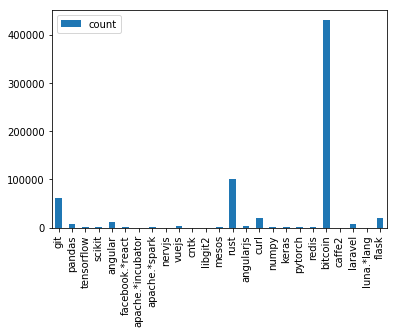

In [36]:
# Show barplot for the counts.
reddit_comments_df.plot.bar();

We notice that most of the values are within acceptable ranges. There are three main outliers:

- `git`: this is one of the oldest and most well-known projects. Seeing this many mentions is not surprising.
- `bitcoin`: Bitcoin seems to have several active communities on Reddit (e.g. r/Bitcoin, r/BitcoinBeginners, r/BitcoinMarkets, etc). Many of them are not related to the core, open-source Bitcoin project, but are about the cryptocurrency in general. In order to get more accurate results, we plan to update our code to count mentions in specific programming-related subreddits such as r/programming.
- `rust`: Rust also has a very active community on Reddit (r/Rust), although our results might also be polluted by the popular [Rust video game](https://store.steampowered.com/app/252490/Rust/). We should be able to get more accurate results with the same method highlighted above.

# 5. Plan Update

Based on the above analysis, we can specify our plan in a more detailed way:

### <span style='color:green'> 5.1 - Defining successful & unsucessful projects </span>
We take the 24 popular projects from the Gitential dataset as examples of successful open source projects. The success of a project can be determined based on e.g.:

- **Number of commits/authors**: the higher the number of commits and authors, the more people working on it. This high motivation of people can be caused by the high utlity that this project provides.
- **Number of issues (on Github) or questions and comments (in StackOverflow or Reddit) about this project**: this is an indicator that the project is popular and people are using it.
- **Number of comments (in Github) or answers (in StackOverflow) and the response time**: a low response time or a high number of replies can indicate that many people use the project.

By analysing these factors on the 24 projects given in the Gitential dataset and using our additional datasets to enrich it, we can get an absolute value range of the number of commits, issues, questions, comments and answers. Since these projects have different sizes (based on line of code) we can calculate a relative number for comparison.

###  <span style='color:green'>5.2 - How to answer the research questions and with which dataset?</span>
We take our research questions from milestone 1 and show possible ways to answer them, based on our improved knowledge after exploring our datasets. The listed columns of a dataset we could use for each question is not complete, but shows a starting point for our data analysis. We may obtain more possibilities and useful information from other columns during later steps.


- *How many contributors are there, and are there time patterns to when they submit their changes?*

**Gitential data**: we plan to look at the number of unique authors (`author_name` and `author_name_dedup`, whichever is not NaN) for each project, and analyze the `committer_time` for each person and globally.

---

- *Is there a certain roles distribution among contributors to the project? For example, do successful projects have people who focus on refactoring code, adding features or fixing bugs?*

**Gitential data**: we plan to answer this by analysing the commits data. For example, `loc_d`, `loc_i`, `comp_d`, and `comp_i` can be used to detect people who focus on refactoring code or enforce style guidelines. `nfiles` could identify people who focus on small or large amounts of files at once, which could indicate bug fixes/small features versus larger feature additions/overhauls. Commit messages (`message`) can be parsed to identify several types of commits. For example: commits that fix issues (e.g. by looking at keywords such as 'Closes' or 'Fixes'), or commits that merge another person's pull requests (by looking for 'Merges ...' commits).

---

- *Are there certain patterns to the commits, such as commit messages length, size or frequency of the commits, etc?*

**Gitential data**: we can analyse possible patterns in the columns `message`, `nfiles` (for the size of the commits) and `committer_time` (for the frequency).

---

- *Are contributors part of a small community/team (e.g. real-life development teams), or are they independent contributors?*

**Gitential data**: we plan to analyze this by checking `committer_email` and `committer_email_dedup` and parsing the domain of the email (e.g. people from the Microsoft team will have `@microsoft` emails), whereas more diverse people are more likely to have their unique email hosts or common email hosts (e.g. `@hotmail` or `@gmail`).

---

- *Can we relate the success / popularity to a responsive / helpful community (e.g. StackOverflow / Reddit subreddits)?*

**StackOverflow dataset**: we plan to count the number of questions related to each of these projects (by making use of `_Tags`), and compute the average response time (using `_CreationDate` and `_PostTypeId`, to get the difference between the question and the first answer). We also plan to check the response time of accepted responses (not just the first answer), by using the `_AcceptedAnswerId` column. Additionally, `_AnswerCount` can also be used as an indicator of a thriving community.

**Reddit dataset**: we plan to count the number of posts and comments about each project, as well as posts in a subreddit for projects that have a subreddit dedicated to them. We might have to focus on certain programming-related subreddits to avoid false matches.

---

- *Can we gain some insight from GitHub issues for a project? For example, the number of open/closed issues or the response time.*

**GitHub API issues**: we plan to do this by looking at the columns `state`, `closed_at` and `created_at` (time for resolution), as well as `created_at` / `parent` for the comments to get the response time.

---

- *Could sentimental analysis of commit messages or issue reports be meaningful? (GitHub API comments)*

**Gitential data**: we plan to analyze commit messages (`message`) with an Python library (NLTK).

**GitHub API comments**: similarly, we plan to analyze issue body texts (`body`).

---

- *Does the choice of programming language play a role in the success of a project?*

We were planning to check the `patches` Gitential datasets for this at first, but we decided to drop this idea after futher consideration, as a proper statistical analysis would probably require thousands of Git projects (24 data points is not sufficient, since this is a very simple and one-dimensional data point).

---

- *Similarly, can projects' licenses or codes of conduct provide us with some insight?*

We were planning to use the Github API to get data for this, but we decided to drop it as well for similar reasons as above.

---

- *Are contributors focused around certain parts of the project?*

**Gitential data**: we decided to postpone this for now due to potential time constraints, as we consider the other questions to be more important. If time allows it, we might be able to explore this at a later stage by checking the `patches` Gitential datasets.

###  <span style='color:green'> 5.3 - Does the retrieved data suit our project aim? </span>

With the above section in mind («*2. How to answer the research questions and with which dataset*»), we can say that we can answer most of our research questions with our retrieved data. Some columns of the data are not mentioned above, but this does not mean that they are useless. We may make use of these later in the analysis as they provide additional information.

To conclude, the retrieved data suits our project aim. In our presentation, we plan to answer each of our research questions in order to present a story that shows common patterns among successful projects.

###  <span style='color:green'>5.4 - Methods & mathematical details in later analysis</span>

**Descriptive statistics**
- Robust statistics: median, quartiles.
- Distribution: normal, heavy-tailed, poisson, exponential.
- Visual inspection: histograms, bar charts, boxplots.

**Quantifying uncertainty** 
- Error bars: standard deviation and confidence interval.
- Bootstrap resampling.

**Relating two variables**
- Correlation coefficients: pearson, spearman.

**Hypothesis testing**
- Testing the significance of null hypothesis to make conclusions.
- Using p-value.

**Classifier for sentiment analysis** (machine learning model)
- The Python library NLTK makes use of classifier algorithms to predict on the given test data set (Git commits and GitHub API comments) whether it is a positive or negative comment (we use two classes).

###  <span style='color:green'>5.5 - Not considered potential alternatives</span>

We are not sonsidering the two datasets `blames` and `patches` in the Gitential data since we would like to focus on the commits based on our research questions. Commits are the most important part for the project and are the main contribution of people.